In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import linear_model

In [14]:
def load_image(image_path):
    im_rgb = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2GRAY)
    return im_rgb, im_gray

def get_thick_edges(im_gray, low_threshold, high_threshold):
    thick_edges = np.zeros_like(im_gray)
    edges = cv2.Canny(im_gray, low_threshold, high_threshold)
    for i in range(-4, 4):
        thick_edges += (np.roll(edges, i, 0) + np.roll(edges, i, 1))
    thick_edges = 1 - (thick_edges > 0).astype(np.uint8)
    return thick_edges

def draw_connected_components(components_indices, components_matrix, im_shape, title, steps_log):
    cc_rgb = np.zeros(im_shape, dtype=np.uint64)
    for c_idx in components_indices:
        y_locations, x_locations = np.where(components_matrix == c_idx)
        cc_rgb[y_locations, x_locations, :] = np.random.randint(0, 255, size=(3, ), dtype=np.uint64)
    steps_log.append((title, cc_rgb))

def get_connected_components(thick_edges, steps_log, im_gray, processing_log):
    num_components, components_matrix = cv2.connectedComponents(thick_edges, connectivity=4)
    draw_connected_components(range(num_components),
                              components_matrix,
                              [im_gray.shape[0], im_gray.shape[1], 3],
                              'Connected Components',
                              processing_log)
    return num_components, components_matrix

def filter_white_components(im_gray, num_components, components_matrix, processing_log):
    # Filter out non white components
    white_components = []
    for c_idx in range(num_components):
        gray_patch = im_gray[np.where(components_matrix == c_idx)]
        patch_size = np.prod(gray_patch.shape)
        if np.sum(gray_patch) / patch_size > 100:
            white_components.append((c_idx, patch_size))
    size_avg = np.average([c for _, c in white_components])

    white_components = [idx for idx, s in white_components if 0.5 * size_avg < s < 2.5 * size_avg]

    # Log
    draw_connected_components(white_components,
                                components_matrix,
                                [im_gray.shape[0], im_gray.shape[1], 3],
                                'White Connected Components',
                                processing_log)
    return white_components

def expand2rgb(im):
    return np.transpose(np.stack([im]*3), axes=(1, 2, 0))

def draw_center_masses(white_components, components_matrix, im_gray, title, steps_log):
    radius = 7
    im_rgb = expand2rgb(im_gray)
    for c_idx in white_components:
        z = np.zeros_like(im_gray)
        z[np.where(components_matrix == c_idx)] = 1
        indices = np.nonzero(z)
        y_cm, x_cm = int(np.mean(indices[0])), int(np.mean(indices[1]))
        im_rgb[(y_cm - radius):(y_cm + radius), (x_cm - radius):(x_cm + radius), :] = np.array([255, 0, 0])
    steps_log.append((title, im_rgb))

def get_center_of_masses(white_components, components_matrix, im_gray, steps_log):
    # Calculate center masses
    y_cms, x_cms = [], []
    for c_idx in white_components:
        z = np.zeros_like(im_gray)
        z[np.where(components_matrix == c_idx)] = 1
        nz_indices = np.nonzero(z)
        y_cm, x_cm = int(np.mean(nz_indices[0])), int(np.mean(nz_indices[1]))
        y_cms.append(y_cm)
        x_cms.append(x_cm)
    # Log
    draw_center_masses(white_components, components_matrix, im_gray, 'Center Masses', steps_log)
    return white_components, np.array(y_cms), np.array(x_cms)[..., None], components_matrix


In [15]:
import cv2
import numpy as np

def load_image(image_path):
    im_rgb = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2GRAY)
    return im_rgb, im_gray

def detect_and_draw_lines(sobel_image, original_image, orientation="vertical"):
    # Apply binary threshold to prepare the Sobel image for Hough Transform
    _, binary = cv2.threshold(sobel_image, 50, 255, cv2.THRESH_BINARY)

    # Perform Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(
        binary,                    # Binary image (edge map)
        rho=1,                     # Distance resolution in pixels
        theta=np.pi/180,           # Angle resolution in radians
        threshold=50,             # Minimum number of intersecting points to detect a line
        minLineLength=10,          # Minimum length of line to be detected
        maxLineGap=10              # Maximum allowed gap between line segments
    )

    # Draw the detected lines on a copy of the original image
    result_image = original_image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if orientation == "vertical":
                # Draw only vertical lines (i.e., where x-coordinates are approximately the same)
                if abs(x1 - x2) < 10:  # Allowable tolerance for a "vertical" line
                    cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            elif orientation == "horizontal":
                # Draw only horizontal lines (i.e., where y-coordinates are approximately the same)
                if abs(y1 - y2) < 10:  # Allowable tolerance for a "horizontal" line
                    cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return result_image, lines

# --- Load your image ---
im_rgb, im_gray = load_image('piano3.png')
processing_log = [('Original Image', im_rgb)]

# --- Vertical Edge Detection (Sobel dx=1, dy=0) ---
sobel_x = cv2.Sobel(im_gray, cv2.CV_64F, dx=1, dy=0, ksize=1)
sobel_x = cv2.convertScaleAbs(sobel_x)
processing_log.append(('Vertical Edge Enhancement (Sobel)', sobel_x))

# --- Horizontal Edge Detection (Sobel dx=0, dy=1) ---
sobel_y = cv2.Sobel(im_gray, cv2.CV_64F, dx=0, dy=1, ksize=1)
sobel_y = cv2.convertScaleAbs(sobel_y)
processing_log.append(('Horizontal Edge Enhancement (Sobel)', sobel_y))

# --- Detect Vertical Lines ---
hough_vertical, vertical_lines = detect_and_draw_lines(sobel_x, im_rgb, orientation="vertical")
processing_log.append(('Hough Transform with Vertical Lines', hough_vertical))

# --- Detect Horizontal Lines ---
hough_horizontal, horizontal_lines = detect_and_draw_lines(sobel_y, im_rgb, orientation="horizontal")
processing_log.append(('Hough Transform with Horizontal Lines', hough_horizontal))

# --- Combine Vertical and Horizontal Lines into a Single Image ---
combined_lines = hough_vertical.copy()
if horizontal_lines is not None:
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]
        # Overlay horizontal lines in blue on the combined image
        if abs(y1 - y2) < 10:  # Horizontal lines only
            cv2.line(combined_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

processing_log.append(('Combined Hough Transform with Vertical and Horizontal Lines', combined_lines))


In [16]:
def filter_center_masses(white_components, x_cms, y_cms, components_matrix, im_gray, processing_log):
    try:
        # Get a linear fit of the center masses by throwing out outliers,
        # then filter out center masses that don't conform with the consensus
        white_components_filtered = white_components.copy()
        x_cms_filtered = x_cms.copy()
        y_cms_filtered = y_cms.copy()
        return white_components_filtered, x_cms_filtered, y_cms_filtered
        model = linear_model.RANSACRegressor()
        model.fit(x_cms, y_cms)
        dists = np.abs(np.array(model.predict(x_cms) - y_cms))
        avg = np.average(dists)
        for component_idx in range(len(white_components)):
            if dists[component_idx] > 10. * avg:
                white_components_filtered.remove(white_components[component_idx])
                x_cms_filtered = np.delete(x_cms_filtered, component_idx)
                y_cms_filtered = np.delete(y_cms_filtered, component_idx)
                print('Removed outlier center mass')
        # Log
        draw_center_masses(white_components_filtered , components_matrix, im_gray, 'Filtered Center Masses', processing_log)
        return white_components_filtered, x_cms_filtered, y_cms_filtered
    except Exception as e:
        print(e)
        pass

In [17]:
def outline_black_key_patch(log_image, inspection_y, inspection_x):
    outline_color = np.array([255, 0, 0])
    log_image[(inspection_y - 15):(inspection_y - 12), (inspection_x - 15):(inspection_x + 15), :] = outline_color
    log_image[(inspection_y + 12):(inspection_y + 15), (inspection_x - 15):(inspection_x + 15), :] = outline_color
    log_image[(inspection_y - 15):(inspection_y + 15), (inspection_x - 15):(inspection_x - 12), :] = outline_color
    log_image[(inspection_y - 15):(inspection_y + 15), (inspection_x + 12):(inspection_x + 15), :] = outline_color

def draw_f_keys(f_keys_indices, components_matrix, gray_im, title, processing_log):
    rgb_im = expand2rgb(gray_im)
    for f_key in f_keys_indices:
        rgb_im[np.where(components_matrix == f_key)] = np.array([0, 0, 255])
    processing_log.append((title, rgb_im))

def classify_white_components(white_components, x_cms, y_cms, im_gray, components_matrix, processing_log):
    # Sort white components by horizontal position
    x_cms, y_cms, white_components = zip(*sorted(zip(x_cms, y_cms, white_components), key=lambda xyw: xyw[0]))

    # Build log image
    log_image = expand2rgb(im_gray)

    # Determine which white component (i.e. piano key) has a black key to its right
    black_key_exists = []
    for idx in range(len(white_components) - 1):

        # Calculate the border between the white key and its right neighbor
        wc_a_patch = np.where(components_matrix == white_components[idx])
        wc_b_patch = np.where(components_matrix == white_components[idx+1])
        border_points = []
        for y in range(max(wc_a_patch[0][0], wc_b_patch[0][0]),
                       min(wc_a_patch[0][-1], wc_b_patch[0][-1])):
            max_x_in_a = np.max(wc_a_patch[1][np.where(wc_a_patch[0] == y)])
            min_x_in_b = np.min(wc_b_patch[1][np.where(wc_b_patch[0] == y)])
            border_points.append((int((min_x_in_b + max_x_in_a)/2.), y))

        # Log - draw borders
        for x, y in border_points:
            log_image[(y-2):(y+2), (x-2):(x+2), :] = np.array([0, 0, 255])

        # Determine a patch along the upper border to inspect
        inspection_radius = 20

        inspection_middle_points = sorted(border_points, key=lambda p: p[1])
        inspection_middle_points = inspection_middle_points[
                                   int(0.1 * len(inspection_middle_points)):
                                   int(0.3 * len(inspection_middle_points))]
        inspection_x, inspection_y = int(np.average([p[0] for p in inspection_middle_points])),\
                                     int(np.average([p[1] for p in inspection_middle_points]))
        patch_value = np.sum(im_gray[(inspection_y-inspection_radius):(inspection_y+inspection_radius),
                             (inspection_x-inspection_radius):(inspection_x+inspection_radius)])

        # If the patch is relatively black, there's a black key there
        black_threshold = inspection_radius*inspection_radius*4*255*0.6
        black_key_exists.append(1 if patch_value < black_threshold else 0)

        # Log - outline inspection patches that saw a black key
        if patch_value < black_threshold:
            outline_black_key_patch(log_image, inspection_y, inspection_x)

    # Log
    processing_log.append(('Borders & Black Keys', log_image))

    # Find a sequence of 3 white keys that have a black key to their right
    # The first of those is an F key
    f_keys = [k - 1 for k in list(np.where(np.convolve(np.array(black_key_exists), [1, 1, 1], mode='same') == 3)[0])]
    f_keys_wc_indices = [white_components[k] for k in f_keys]
    print("f_keys:", f_keys)

    # Log
    draw_f_keys(f_keys_wc_indices, components_matrix, im_gray, 'F Key Detection', processing_log)

    # Assign a note to each white component,
    # according to its position in relation to the F notes
    notes = []
    keys_order = ['F', 'G', 'A', 'B', 'C', 'D', 'E']
    for wc_idx in range(len(white_components)):
        offset = (wc_idx - f_keys[0]) % 7
        notes.append(keys_order[offset])
    return white_components, y_cms, x_cms, notes

def highlight_note(rgb_im, components_matrix, note_cc_id, color_delta):
    rgb_im[np.where(components_matrix == note_cc_id)] -= color_delta
    rgb_im[np.where(components_matrix == note_cc_id)] = \
        np.clip(rgb_im[np.where(components_matrix == note_cc_id)], 0, 255)
    
def put_text(rgb_im, y, x, text):
    radius = 20
    rgb_im[(y - radius):(y + radius), (x - radius):(x + radius), :] = np.array([0, 0, 0])
    cv2.putText(rgb_im, text, (x - 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color=255, thickness=2)

def full_annotation(rgb_im, y_cms, x_cms, white_component_notes, white_components, components_matrix, processing_log):
    for idx, wc_idx in enumerate(white_components):
        color_delta = (np.array([100, 100, 0] if idx % 2 == 0 else [100, 0, 100], dtype=np.uint8))
        highlight_note(rgb_im, components_matrix, wc_idx, color_delta)
        put_text(rgb_im, y_cms[idx], x_cms[idx], white_component_notes[idx])
    processing_log.append(('Notes', rgb_im))

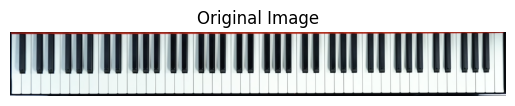

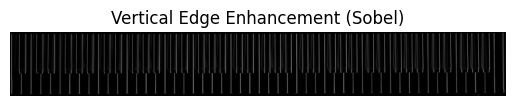

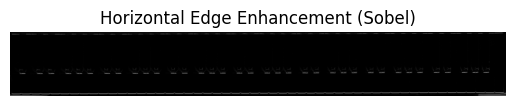

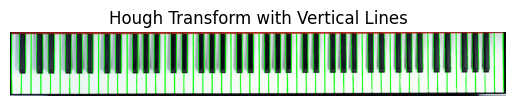

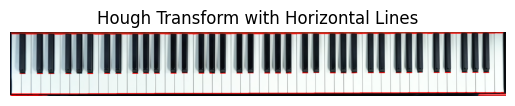

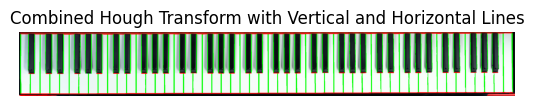

In [18]:
for title, img in processing_log:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()  

# white_components, y_cms, x_cms, white_component_notes = classify_white_components(
#         white_components_filtered, np.squeeze(x_cms_filtered), y_cms_filtered,
#         im_gray, components_matrix, processing_log)

# full_annotation(im_rgb.copy(), y_cms, x_cms, white_component_notes,
#                 white_components, components_matrix, processing_log)

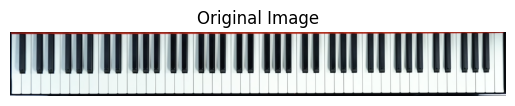

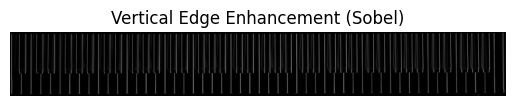

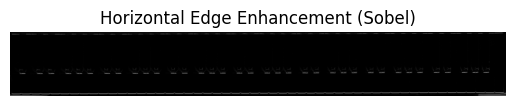

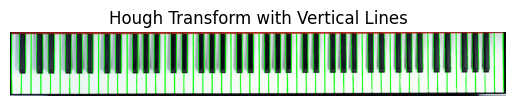

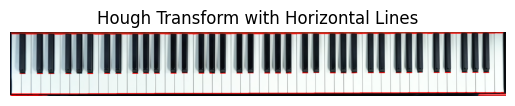

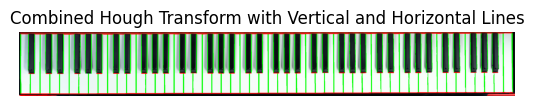

In [19]:
for title, img in processing_log:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()